In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from keras.utils.vis_utils import plot_model
from numpy import array
import pickle
import numpy as np
import os
import cv2
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding
import tensorflow as tf
from keras.models import load_model 

## Loading Images and Captions

In [ ]:
#just checking the number of images in the dataset
l=os.listdir("/content/drive/MyDrive/Image Caption Generator/Flicker8k_Dataset")
print(len(l))

8091


In [ ]:
#converting the text files to pandas dataframe
image_tokens=pd.read_csv("/content/drive/MyDrive/Image Caption Generator/all_captions/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("/content/drive/MyDrive/Image Caption Generator/all_captions/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("/content/drive/MyDrive/Image Caption Generator/all_captions/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("/content/drive/MyDrive/Image Caption Generator/all_captions/Flickr_8k.devImages.txt",names=["img_id"])

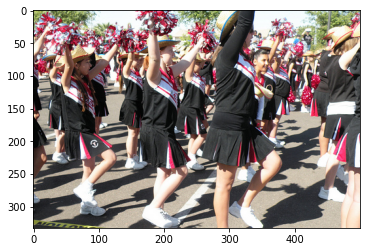

In [ ]:
#visualising one of the train images
img=cv2.imread("/content/drive/MyDrive/Image Caption Generator/Flicker8k_Dataset"+ "/" +train_image_names.img_id[11])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

## Preprocessing Data

In [ ]:
#removing the #'s from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [ ]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [ ]:
image_tokens.head()

,img_id,img_caption
0,1305564994_00513f9a5b.jpg,<start> A man in street racer armor be examine...
1,1305564994_00513f9a5b.jpg,<start> Two racer drive a white bike down a ro...
2,1305564994_00513f9a5b.jpg,<start> Two motorist be ride along on their ve...
3,1305564994_00513f9a5b.jpg,<start> Two person be in a small race car driv...
4,1305564994_00513f9a5b.jpg,<start> Two person in race uniform in a street...


In [ ]:
image_tokens['img_caption'][1]

'<start> Two racer drive a white bike down a road . <end>'

In [ ]:
train_image_names.head()

,img_id
0,2513260012_03d33305cf.jpg
1,2903617548_d3e38d7f88.jpg
2,3338291921_fe7ae0c8f8.jpg
3,488416045_1c6d903fe0.jpg
4,2644326817_8f45080b87.jpg


###Creating dictionaries to map image_id and their corresponding captions

In [ ]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

In [ ]:
train_captions['3328397409_092de2bd32.jpg']

['<start> A man be snowboard over a pipe . <end>',
 '<start> A man snowboard over an upturned garbage can in the wood . <end>',
 '<start> A person in a black jacket and light blue pants appear in the air with a custom snowboard . <end>',
 '<start> A person ride a snowboard be in the air jump over a trashcan on a snowmobile . <end>',
 '<start> A snowboard jump over an upturned garbage can . <end>']

In [ ]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

In [ ]:
test_captions['2473791980_805c819bd4.jpg']

['<start> a lone parasailer surf in the ocean wear a black swimsuit . <end>',
 '<start> A man be kite surf away from the camera . <end>',
 '<start> A man be sky surf on the water . <end>',
 '<start> A man waterskis while attach to a parachute . <end>',
 '<start> A waterskier cut through the blue water with sailboat in the background . <end>']

In [ ]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

In [ ]:
validation_captions['3425756814_13909354d4.jpg']

['<start> A male tennis player hold his tennis racket . <end>',
 '<start> A man hold a tennis racket be look in the distance with his hand over his mouth . <end>',
 '<start> A man in a sleeveless blue tennis shirt blow kiss to fan . <end>',
 '<start> A tennis player hold one hand to his mouth and the other hold a racket . <end>',
 '<start> a tennis player in a green striped shirt be hold his hand up to his mouth . <end>']

# Extracting features from Images using RestNet50 

##Loading ResNet50 model

In [ ]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))

##Extracting Features from training images

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict train_features
path="/content/drive/MyDrive/Image Caption Generator/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

In [ ]:
with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [ ]:
train_features = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/train_encoded_images.p', 'rb'))

##Extracting Features from testing images

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="/content/drive/MyDrive/Image Caption Generator/Flicker8k_Dataset/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

In [ ]:
with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [ ]:
test_features = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/test_encoded_images.p', 'rb'))

## Extracting Features for Validation Images

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="/content/drive/MyDrive/Image Caption Generator/Flicker8k_Dataset/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

In [ ]:
with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

In [ ]:
validation_features = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/validation_encoded_images.p', 'rb'))

#Preparing Captions to feed into the model

##Vocabulary size and maximum length

In [ ]:
all_captions = []
for i in range(len(image_tokens)):
  cap = image_tokens['img_caption'][i]
  all_captions.append(cap)

all_words = " ".join(all_captions)
print()
print(len(all_words))
unique_words = list(set(all_words.strip().split(" ")))
print(len(unique_words))


2687095
7407


In [ ]:
with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/all_captions.p", "wb" ) as caps:
     pickle.dump(all_captions, caps )

with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/all_words.p", "wb" ) as words:
     pickle.dump(all_words, words )

with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/unique_words.p", "wb" ) as unique:
     pickle.dump(unique_words, unique )

In [ ]:
all_captions = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/all_captions.p', 'rb'))
all_words = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/all_words.p', 'rb'))
unique_words = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/unique_words.p', 'rb'))

In [ ]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

##Mapping words to indices and indices to words

In [ ]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

In [ ]:
with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/words_to_indices.p", "wb" ) as w2i:
     pickle.dump(words_to_indices, w2i )

with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/indices_to_words.p", "wb" ) as i2w:
     pickle.dump(indices_to_words, i2w )

In [ ]:
words_to_indices = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/words_to_indices.p', 'rb'))
indices_to_words = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/indices_to_words.p', 'rb'))

##Transforming data into dictonary mapping of image_id to encoded captions

In [ ]:
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])




100%|██████████| 6000/6000 [00:00<00:00, 60952.50it/s]


In [ ]:
validation_encoded_captions={}
for img_id in tqdm(validation_captions):
  validation_encoded_captions[img_id]=[]
  for i in range(5):
    validation_encoded_captions[img_id].append([words_to_indices[s] for s in validation_captions[img_id][i].split(" ")])




100%|██████████| 1000/1000 [00:00<00:00, 53935.63it/s]


In [ ]:
test_encoded_captions={}
for img_id in tqdm(test_captions):
  test_encoded_captions[img_id]=[]
  for i in range(5):
    test_encoded_captions[img_id].append([words_to_indices[s] for s in test_captions[img_id][i].split(" ")])




100%|██████████| 1000/1000 [00:00<00:00, 40031.92it/s]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')




  0%|          | 0/6000 [00:00<?, ?it/s]


 48%|████▊     | 2899/6000 [00:00<00:00, 28982.22it/s]


100%|██████████| 6000/6000 [00:00<00:00, 26884.27it/s]


In [ ]:
for img_id in tqdm(validation_encoded_captions):
  validation_encoded_captions[img_id]=pad_sequences(validation_encoded_captions[img_id], maxlen=max_length, padding='post')




100%|██████████| 1000/1000 [00:00<00:00, 20810.55it/s]


In [ ]:
for img_id in tqdm(test_encoded_captions):
  test_encoded_captions[img_id]=pad_sequences(test_encoded_captions[img_id], maxlen=max_length, padding='post')




100%|██████████| 1000/1000 [00:00<00:00, 21931.12it/s]


In [ ]:
with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/train_encoded_captions.p", "wb" ) as pickle_f:
    pickle.dump(train_encoded_captions, pickle_f )

In [ ]:
with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/validation_encoded_captions.p", "wb" ) as pickle_f:
    pickle.dump(validation_encoded_captions, pickle_f )

In [ ]:
with open( "/content/drive/MyDrive/Image Caption Generator/Pickles/test_encoded_captions.p", "wb" ) as pickle_f:
    pickle.dump(test_encoded_captions, pickle_f )

In [ ]:
train_encoded_captions = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/train_encoded_captions.p', 'rb'))

In [ ]:
validation_encoded_captions = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/validation_encoded_captions.p', 'rb'))

In [ ]:
test_encoded_captions = pickle.load(open('/content/drive/MyDrive/Image Caption Generator/Pickles/test_encoded_captions.p', 'rb'))

In [ ]:
train_encoded_captions['2513260012_03d33305cf.jpg']

array([[3958, 3309, 7339, 3462, 7177,  865, 2347,  614, 5385, 3462,  393,
        2191,  498, 7147,  838,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [3958, 2822, 3462, 2914, 1566, 3462, 6496,  498,  838,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [3958, 4570, 3462, 2914, 4122,  302, 3996, 2191, 2491, 7348, 7147,
         838,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [3958, 4570, 3462, 3898, 4265,  393, 2191,  498, 7147,  838,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

In [ ]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


#Models

##Data Generator for Modelling

In [ ]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [array(X1), array(X2)], array(Y)
      X1, X2, Y = list(), list(), list()
      n=0

## Model 1

In [ ]:
#model 
# tf.keras.backend.clear_session()
# model_1.reset_states()

input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model_1=Model(inputs=[input_1,input_2],outputs=dense_3)

model_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 256)      1896448     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________________________________________________

##Ploting Model 1

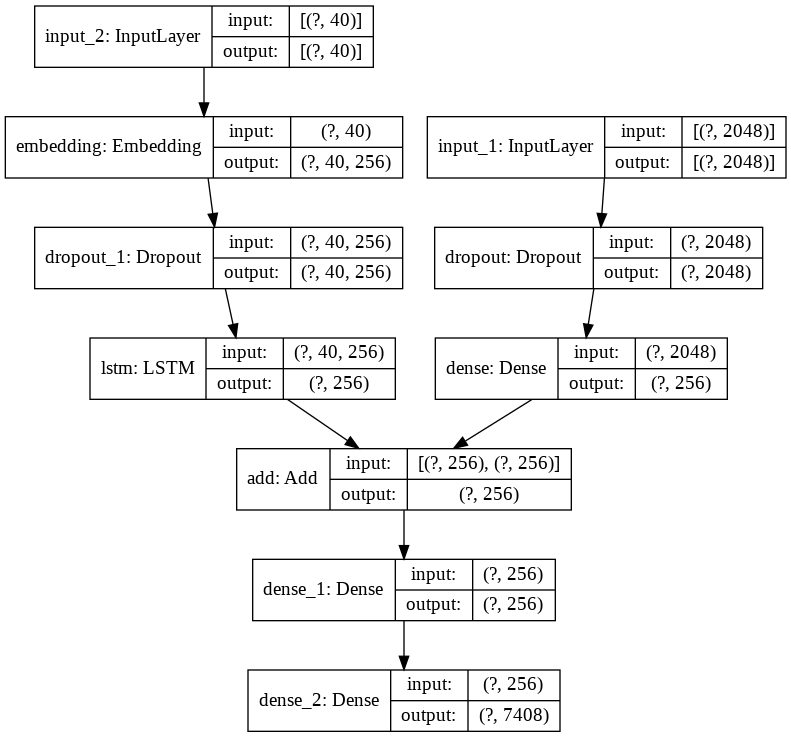

In [ ]:
plot_model(model_1, to_file='/content/drive/MyDrive/Image Caption Generator/Plots/plot_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

## Training Model 1

In [ ]:
# epochs=50
# no_of_photos=5
# train_steps=len(train_encoded_captions)//no_of_photos
# validaiton_steps = len(validation_encoded_captions)//no_of_photos
# for i in range(epochs):
#   train_generator = data_generator(train_encoded_captions,train_features,no_of_photos)
#   validation_generator = data_generator(validation_encoded_captions,validation_features,no_of_photos)
#   history_1 = model_1.fit(train_generator, steps_per_epoch=train_steps,
#                           validation_data=validation_generator, 
#                           epochs=epochs,verbose=1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(history_1.history['accuracy'][0])
print(history_1.history['val_accuracy'][0])

0.8028991222381592
0.7972000241279602


##Saving Model 1

In [ ]:
model_1.save("/content/drive/MyDrive/Image Caption Generator/Model/model_1.h5") 

## Loading Model 1

In [ ]:
loaded_model_1 = load_model("/content/drive/MyDrive/Image Caption Generator/Model/model_1.h5") 

##Predicting Captions on Test Set

In [ ]:
def caption_generator(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = loaded_model_1.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("/content/drive/MyDrive/Image Caption Generator/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  candidate=caption_generator(photo)
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  score = sentence_bleu(reference, candidate)
  print("Reference Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print(" ")  
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print(" ")
  print("bleu score: ",np.round(score,2))
  print(" ")
  if(i==75):
    break

Output hidden; open in https://colab.research.google.com to view.

# Model 2

In [ ]:
tf.keras.backend.clear_session()
model_2.reset_states()

input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)
dense_2=Dense(256,activation='relu')(dense_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256, return_sequences=True)(dropout_2)
lstm_2=LSTM(256)(lstm_1)

add_1=add([dense_1,lstm_2])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model_2=Model(inputs=[input_1,input_2],outputs=dense_3)

model_2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 256)      1896448     input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 40, 256)      0           embedding[0][0]                  
_______________________________________________________________________________________

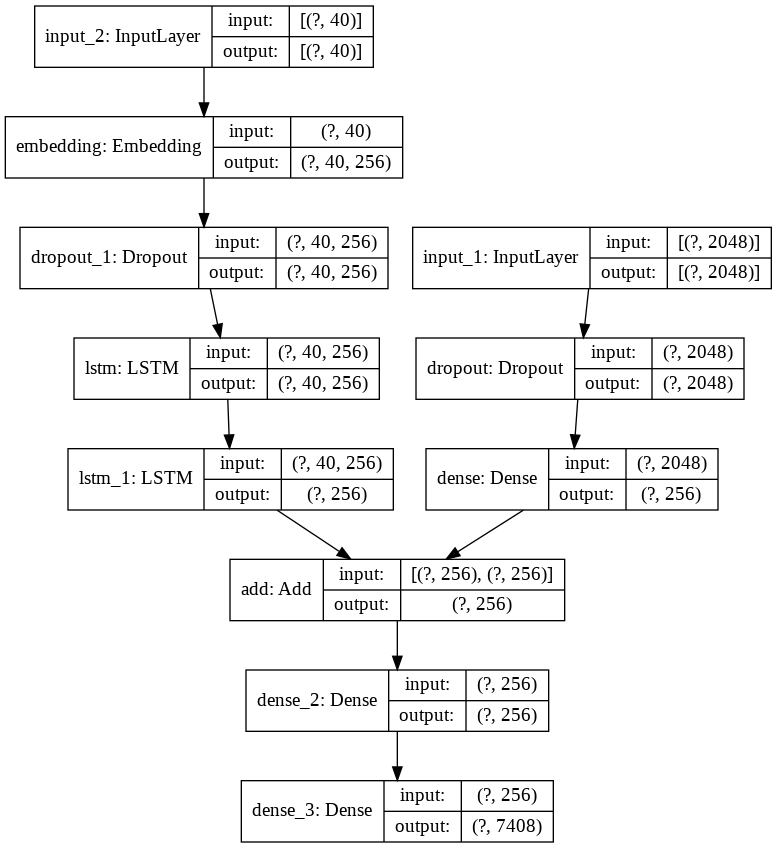

In [ ]:
plot_model(model_2, to_file='/content/drive/MyDrive/Image Caption Generator/Plots/plot_2.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
epochs=50
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  validation_generator = data_generator(validation_encoded_captions,validation_features,no_of_photos)
  history_2 = model_2.fit(generator,epochs=epochs,steps_per_epoch=steps, validation_data=validation_generator,verbose=1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(history_2.history['accuracy'][0])
print(history_2.history['val_accuracy'][0])

0.8209674954414368
0.7991794943809509


In [ ]:
from keras.models import load_model 
model_2.save("/content/drive/MyDrive/Image Caption Generator/Model/model_2.h5")

In [ ]:
loaded_model_2 = load_model("/content/drive/MyDrive/Image Caption Generator/Model/model_2.h5") 

In [ ]:
def caption_generator(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = loaded_model_2.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  return final

In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("/content/drive/MyDrive/Image Caption Generator/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  candidate=caption_generator(photo)
  reference=[]
  score = []
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
    s = sentence_bleu(list_caps, candidate)
    score.append(s)
  print("Reference Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print(" ")  
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print(" ")
  print("bleu score: ",np.round(np.mean(score),2))
  print(" ")
  if(i==50):
    break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
tf.keras.backend.clear_session()
#model_3.reset_states()

input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)
dense_2=Dense(256,activation='relu')(dense_1)


input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=Bidirectional(LSTM(256, return_sequences=True))(dropout_2)
lstm_2=Bidirectional(LSTM(256, return_sequences=True))(lstm_1)
lstm_3=LSTM(256)(lstm_2)

add_1=add([dense_2,lstm_3])
dense_3=Dense(256,activation='relu')(add_1)
dropout_3=Dropout(0.2)(dense_3)
dense_4=Dense(vocab_size,activation='softmax')(dropout_3)

model_3=Model(inputs=[input_1,input_2],outputs=dense_4)
model_3.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 256)      1620224     input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 40, 256)      0           embedding[0][0]                  
_______________________________________________________________________________________

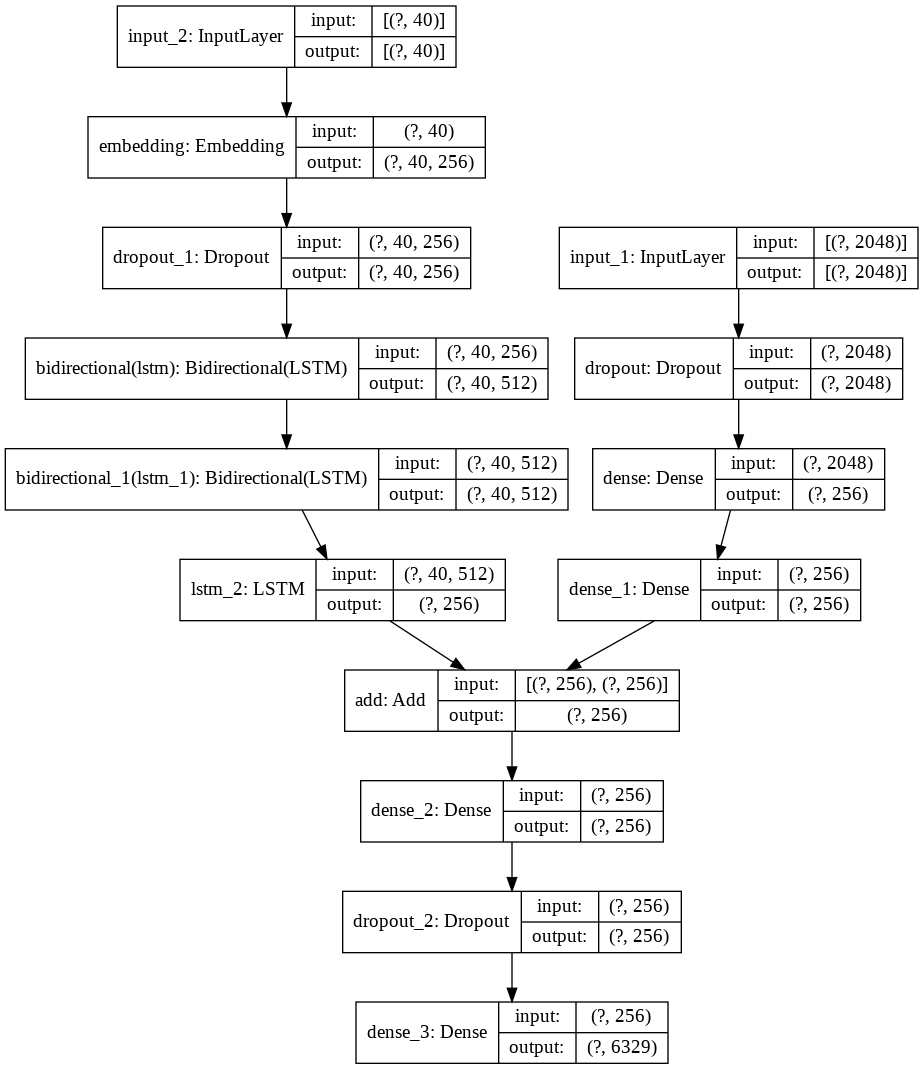

In [ ]:
plot_model(model_3, to_file='/content/drive/MyDrive/Image Caption Generator/Plots/plot_3.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_3.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
epochs=5
no_of_photos=5
#steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model_3.fit(generator,epochs=epochs,verbose=1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from keras.models import load_model 
model_3.save("/content/drive/MyDrive/Image Caption Generator/Model/model_3.h5")

In [ ]:
loaded_model_3 = load_model("/content/drive/MyDrive/Image Caption Generator/Model/model_3.h5") 

In [ ]:
def caption_generator(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = loaded_model_3.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  return final

In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("/content/drive/MyDrive/Image Caption Generator/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  candidate=caption_generator(photo)
  reference=[]
  score = []
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
    s = sentence_bleu(list_caps, candidate)
    score.append(s)
  # a = sentence_bleu(reference, candidate)
  print("Reference Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print(" ")  
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print(" ")
  print("bleu score: ",np.round(np.mean(score),2))
  # print("bleu score: ",np.round(a,2))
  print(" ")
  if(i==25):
    break

Output hidden; open in https://colab.research.google.com to view.